## Chapter 10: Algorithm Analysis

*Definition*: Consider two functions $f$ and $g$. We say that $f(n)$ is $O(g(n))$ or “big-O” of $g(n)$ if

$$\lim_{n \rightarrow \infty}\frac{f(n)}{g(n)} = C$$

for some $0<C<\infty$

Generally, $g(n)$ is a simple function, like a power, exponential or a power times a log.

It's a good time to know how fast functions grow relative to each other.  List the following in lowest to highest growth. $f(n)$ grows faster than $g(n)$ if $\lim_{n \rightarrow \infty} f(n)/g(n) = \infty$.
- $e^n$
- $n^2$ 
- $e^{n^2}$
- $n^2 \ln(n)$
- $n!$

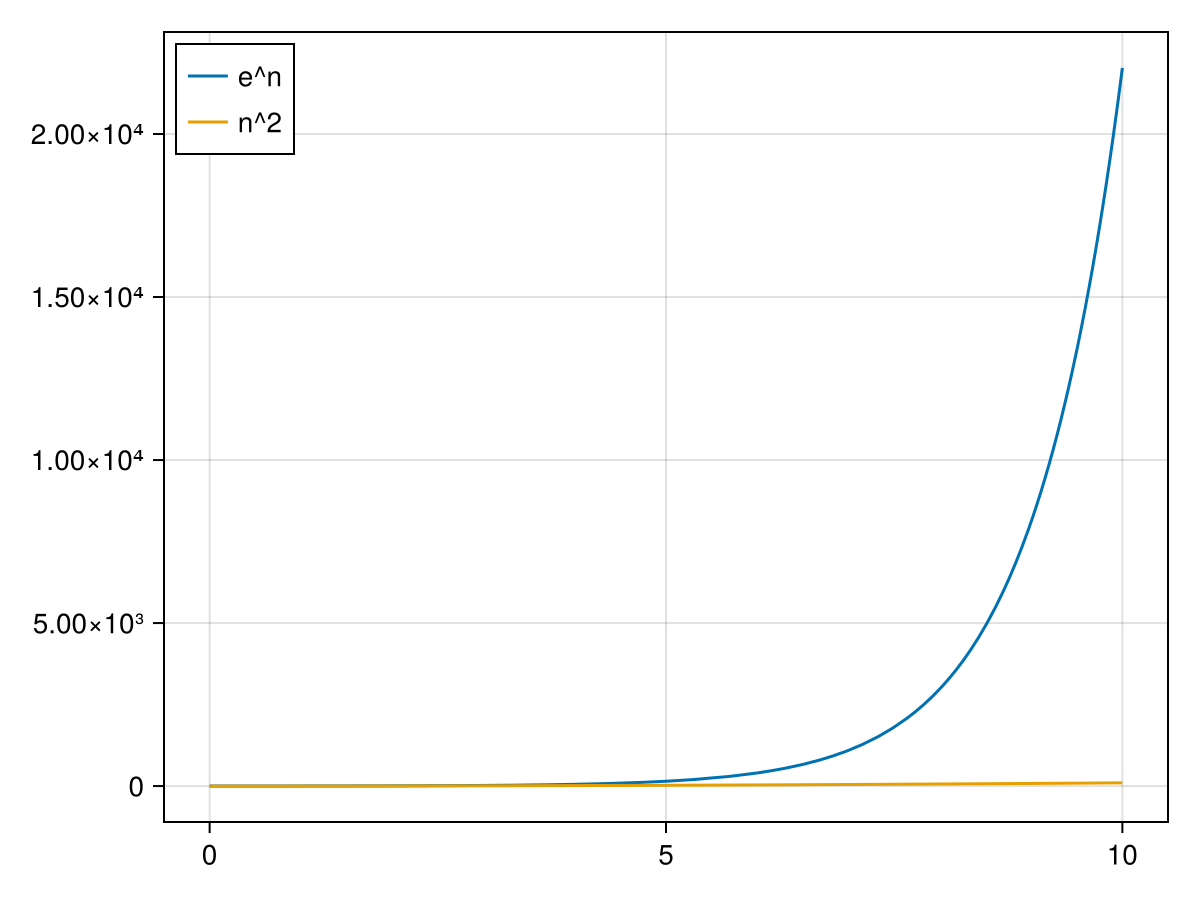

In [13]:
fig, ax = lines(0..10, n->exp(n), label = "e^n")
lines!(ax, 0..10, n->n^2, label = "n^2")
axislegend(ax, position = :lt)
fig

Find big-O for the following:
* $n^2+e^n$
* $3n^2+e^{-n}$
* $n + n \ln (n)$

### Polynomial Evaluation

Recall that a polynomial is

$$p(x) = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + \cdots + a_n x^n$$

For example, a quadratic is a polynomial like $q(x)= 3x^2+7x-2$

The simple way to evaluate the polynomial is to find each power of x and then multiply by the coefficient.  Here's a function that takes an array of coefficients and a value $x$ and calculates $p(x)$.  

In [4]:
function polyEval(coeffs::Vector{T}, x::S) where {T <: Number, S <: Number}
  local sum = zero(T)

  # we will use a simple power function that is not very efficient:
  function pow(x::T,n::Int) where T <: Number
    local prod = one(T)
    for j=1:n
      prod *=x
    end
    prod
  end

  # then we have the sum of all of the terms:
  for n=1:length(coeffs)
    sum += coeffs[n]*pow(x,n-1)
  end
  sum
end

polyEval (generic function with 1 method)

note: we will be explaining the `where {T <: Number, S <: Number}` later.  This allows the ability to evaluate polynomials at any type of number. 

The following evaluates $q(1.5)$ for the quadratic above

In [5]:
polyEval([-2,7,3],1.5)

15.25

In [16]:
-2+7*(1.5)+3*(1.5)^2

15.25

And here is the polynomial $p(x)=1+2x+3x^2+4x^3$ evaluated at $x=4$

In [17]:
polyEval([1,2,3,4],4)

313

We want to see how polynomial evaluation occurs for a given value of $n$, the degree of the polynomial.  We can do this two different ways:

1. Use some analytic techniques
2. Run some code and analyze.

For #1, we note that the number of multiplications for evaluating a polynomial of degree $n$ is

$$0+1+2+3+4+\cdots+(n+1)= \frac{(n+1)(n+2)}{2}$$

The number of additions is $n$. Overall the number of operations then is

$$\frac{(n+1)(n+2)}{2} +n$$

What is the order (big-o) of this?

For #2, we will do the following.  First need to load (and probably add) some packages

In [6]:
using BenchmarkTools, CairoMakie, LsqFit, Random
CairoMakie.activate!()
Makie.inline!(true)

true

In [19]:
Random.seed!(132)

TaskLocalRNG()

The following make an array of times that store the evaluate times of the polynomial evaluation.  Although we only fill part of the array so it doesn't take foreever.

In [11]:
times = zeros(351)
r = 1:50:351
for i=r
  coeffs = rand(i+1)
  times[i] = @belapsed polyEval($coeffs,1/3)
end

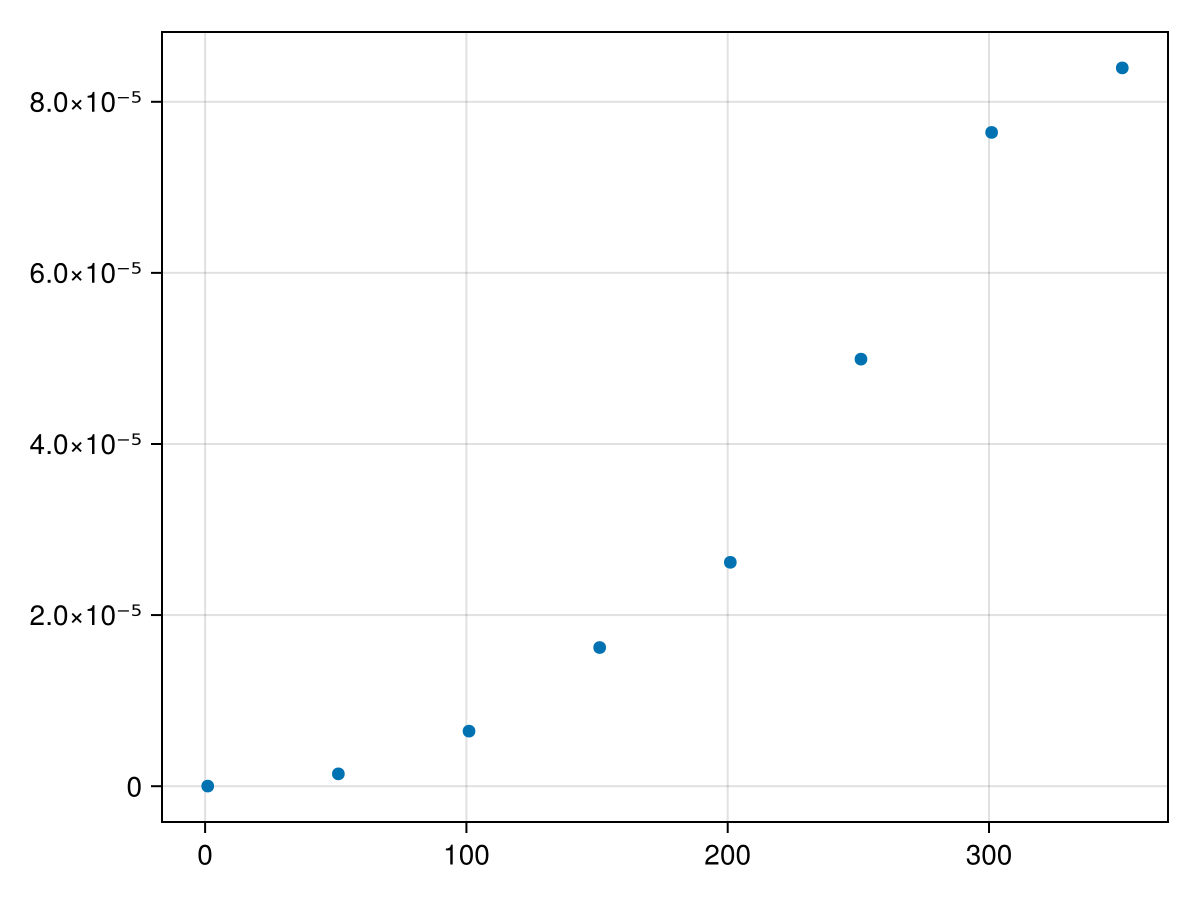

In [12]:
fig, ax = scatter(r,times[r])

Although this looks quadratic, let's see if it is.  We can find the data to a quadratic using the following:

In [13]:
 model(t, p) = @. p[1]+p[2]*t+p[3]*t^2

model (generic function with 1 method)

In [14]:
fit = curve_fit(model, r, times[r], [1e-8,1e-8,1e-8]);

And if we want the parameters

In [15]:
fit.param

3-element Vector{Float64}:
 -1.546919530240552e-6
  2.3975463346622436e-8
  6.779015244187869e-10

The following is the confidence intervals for each of the paramters. 

In [16]:
confidence_interval(fit, 0.05)

3-element Vector{Tuple{Float64, Float64}}:
 (-1.399076103423814e-5, 1.0896921973757036e-5)
 (-1.412356555000592e-7, 1.8918658219330407e-7)
 (2.264173861577631e-10, 1.1293856626798107e-9)

Because the first two contain 0, we don't include them and remodel using only the $t^2$ term: 

In [17]:
fit2 = curve_fit((t,p)-> p[1].*t.^2,r,times[r],[1e-8]);

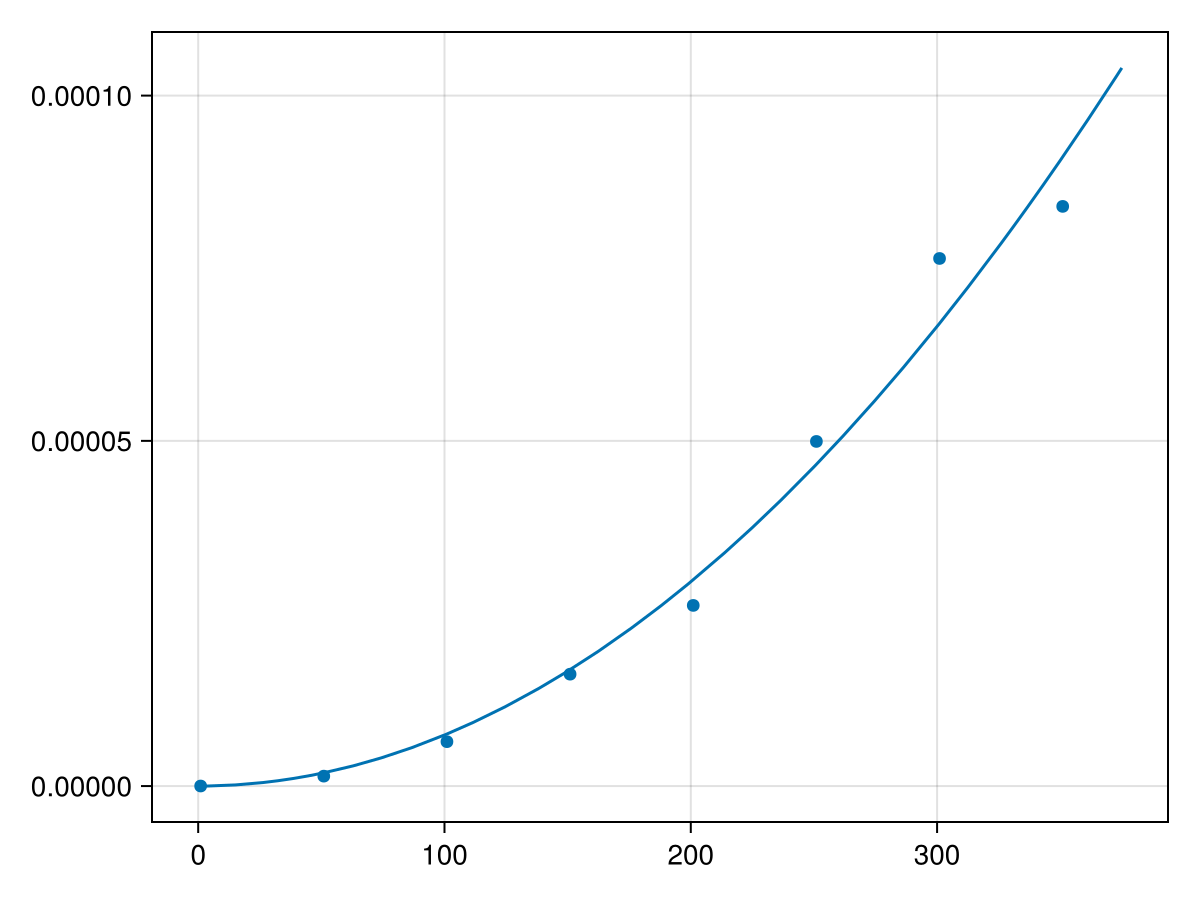

In [18]:
lines!(ax, 0..375,n->fit2.param[1]*n^2)
fig

### Horner's Method
Next, we are going to do an alternative way of evaluating a polynomial.  This is called Horner's form. 

The polynomial

$$p(x) = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + \cdots + a_n x^n$$

can be written:

$$(a_n x +a_{n-1})x + a_{n-2})x + \cdots + a_2)x^2 + a_1)x + a_0$$ 

and the result is that there are $n$ multiplications and $n$ additions. So this should be faster.

In [19]:
function horner(coeffs::Vector{T},x::S) where {T <: Number, S <: Number}
  result = coeffs[end]
  for i=length(coeffs)-1:-1:1
    result = x*result+coeffs[i]
  end
  result
end

horner (generic function with 1 method)

In [20]:
polyEval([1,2,3,4],4)

313

In [21]:
horner([1,2,3,4],4)

313

In [27]:
htimes = zeros(Float64,351)
for i=r
  coeffs = rand(Float64,i)
  htimes[i] = @belapsed horner($coeffs,1/3)
end

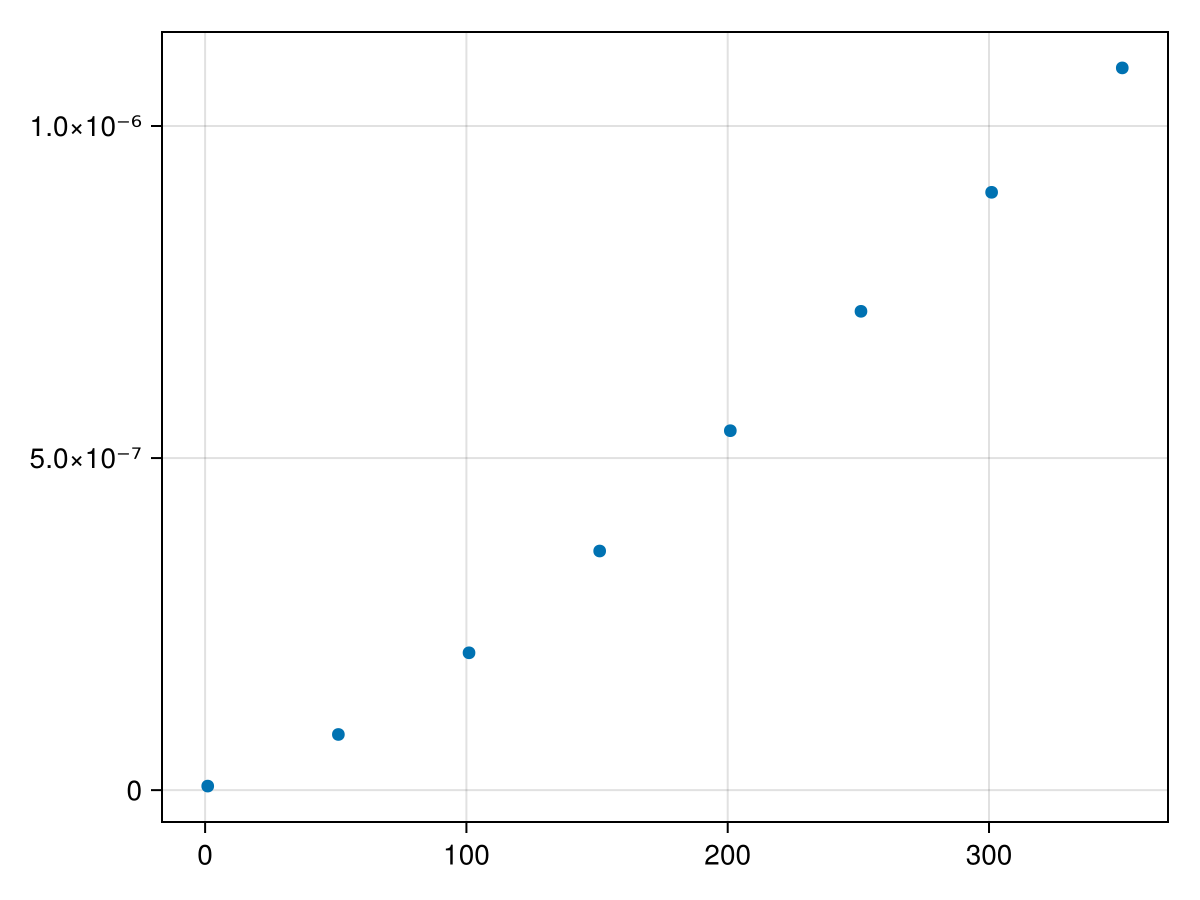

In [28]:
fig, ax = scatter(r,htimes[r])

In [29]:
fit3 = curve_fit(model, r, htimes[r], [1e-8,1e-8,1e-8]);

In [30]:
fit3.param

3-element Vector{Float64}:
 -1.482027310224349e-8
  2.0537234688372138e-9
  3.2128976768863135e-12

In [31]:
confidence_interval(fit3)

3-element Vector{Tuple{Float64, Float64}}:
 (-5.5412573276917174e-8, 2.5772027072430197e-8)
 (1.5147983044284748e-9, 2.5926486332459527e-9)
 (1.7401386692673348e-12, 4.685656684505292e-12)

Only the 2nd parameter (the linear one) is significant so generate a new model with just that term:

In [32]:
fit4 = curve_fit((t,p)->p[1].*t,r,htimes[r],[1e-8]);

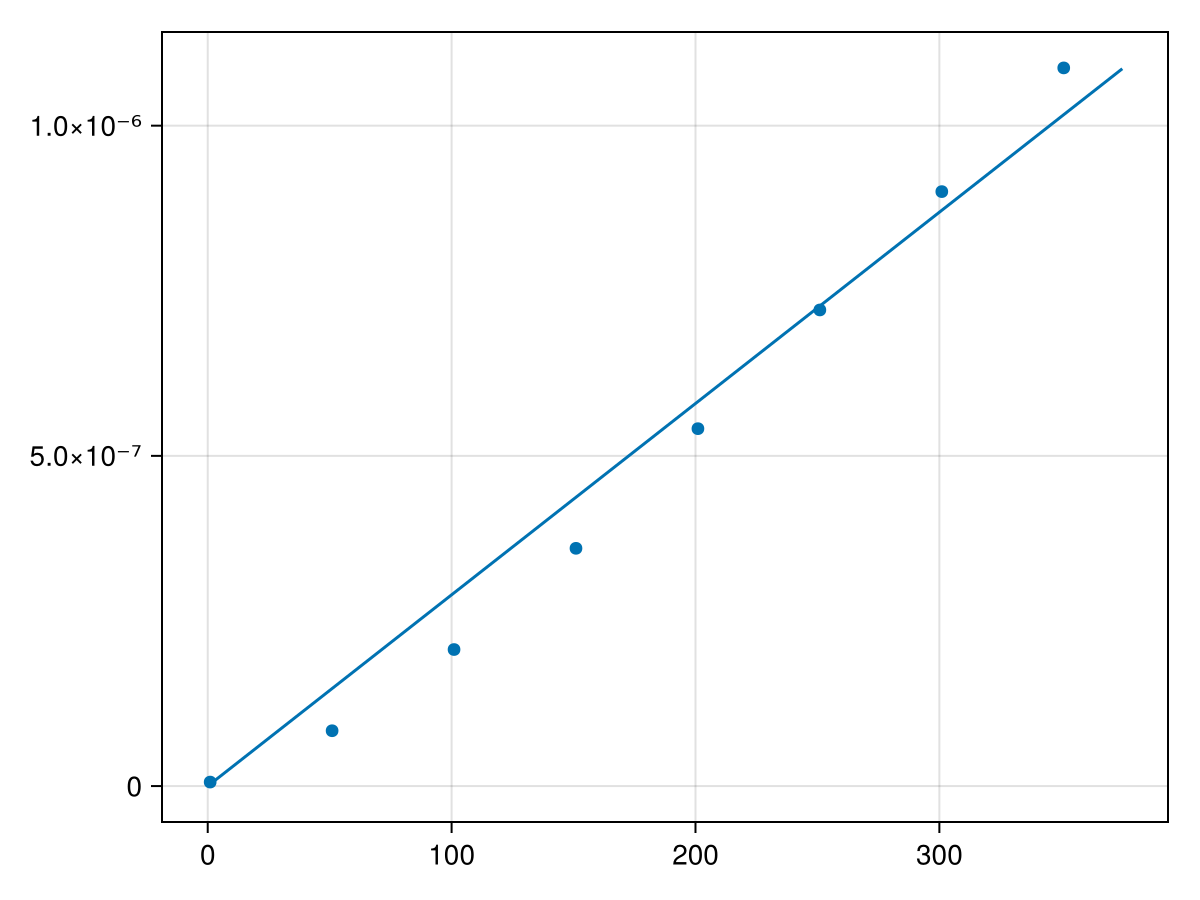

In [33]:
lines!(ax,0..375, n->fit4.param[1]*n)
fig

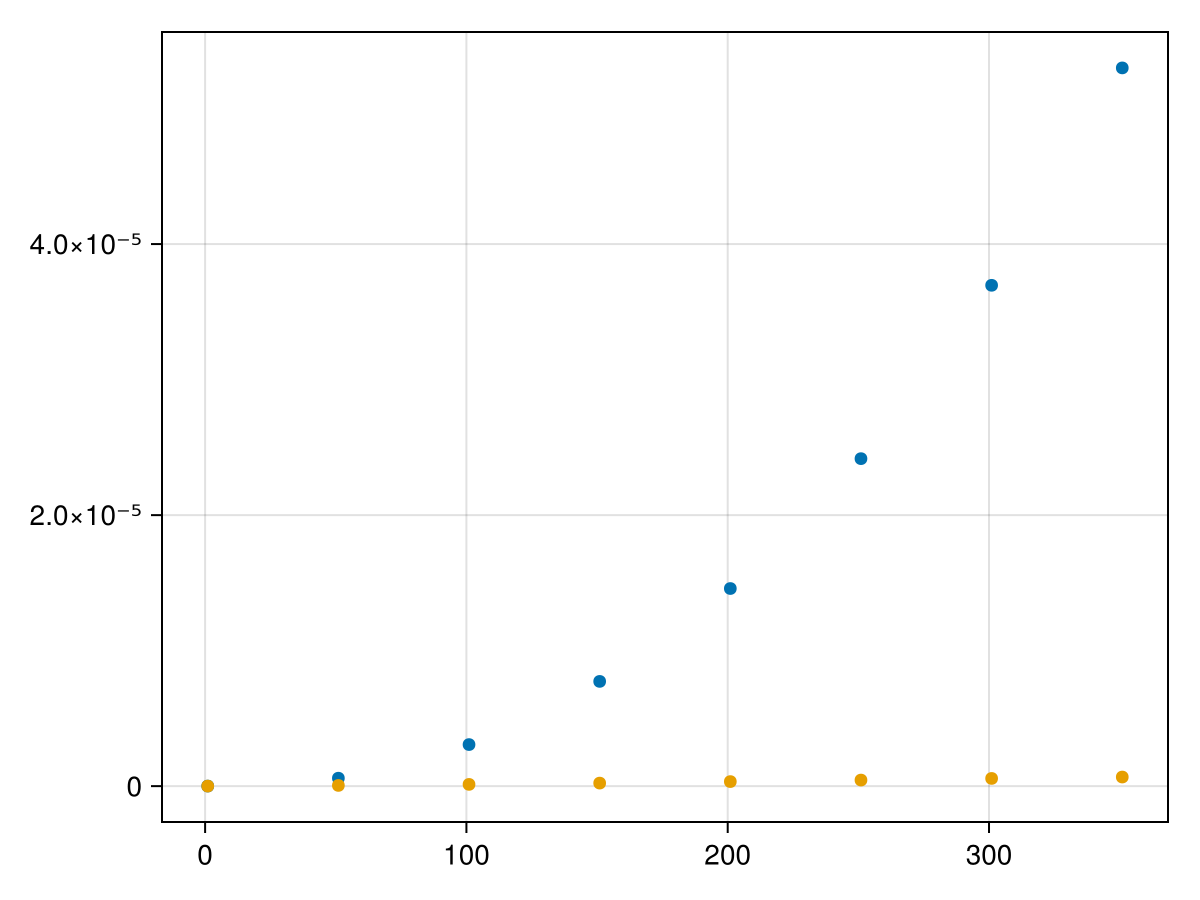

In [36]:
fig, ax = scatter(r,times[r])
scatter!(ax, r,htimes[r])
fig

### Testing the speed of Primes

From Chapter 9, we developed the following function that tests for being prime.  In this section, we will determine the order of this algorithm:

In [37]:
function isPrime6(n::Integer)
  if n == 2
    return true
  elseif n%2==0
    return false
  end
  for k=3:2:round(Int,sqrt(n))
    if n%k==0
      return false
    end
  end
  true
end

isPrime6 (generic function with 1 method)

In [38]:
using Primes

The following generates an array of prime numbers and then determines the elasped time  to determine whether or not each is a prime number.  Note: we are only going to check primes, because these are the worst-case. The function will bail out early (less time) if the number is not prime. 

In [39]:
the_primes = map(nextprime,5_000_000:5_000_000:100_000_000)

20-element Vector{Int64}:
   5000011
  10000019
  15000017
  20000003
  25000009
  30000001
  35000011
  40000003
  45000017
  50000017
  55000013
  60000011
  65000011
  70000027
  75000007
  80000023
  85000007
  90000049
  95000011
 100000007

In [40]:
prime_times=Float64[]
for p in the_primes
  push!(prime_times, @belapsed isPrime6($p))
end

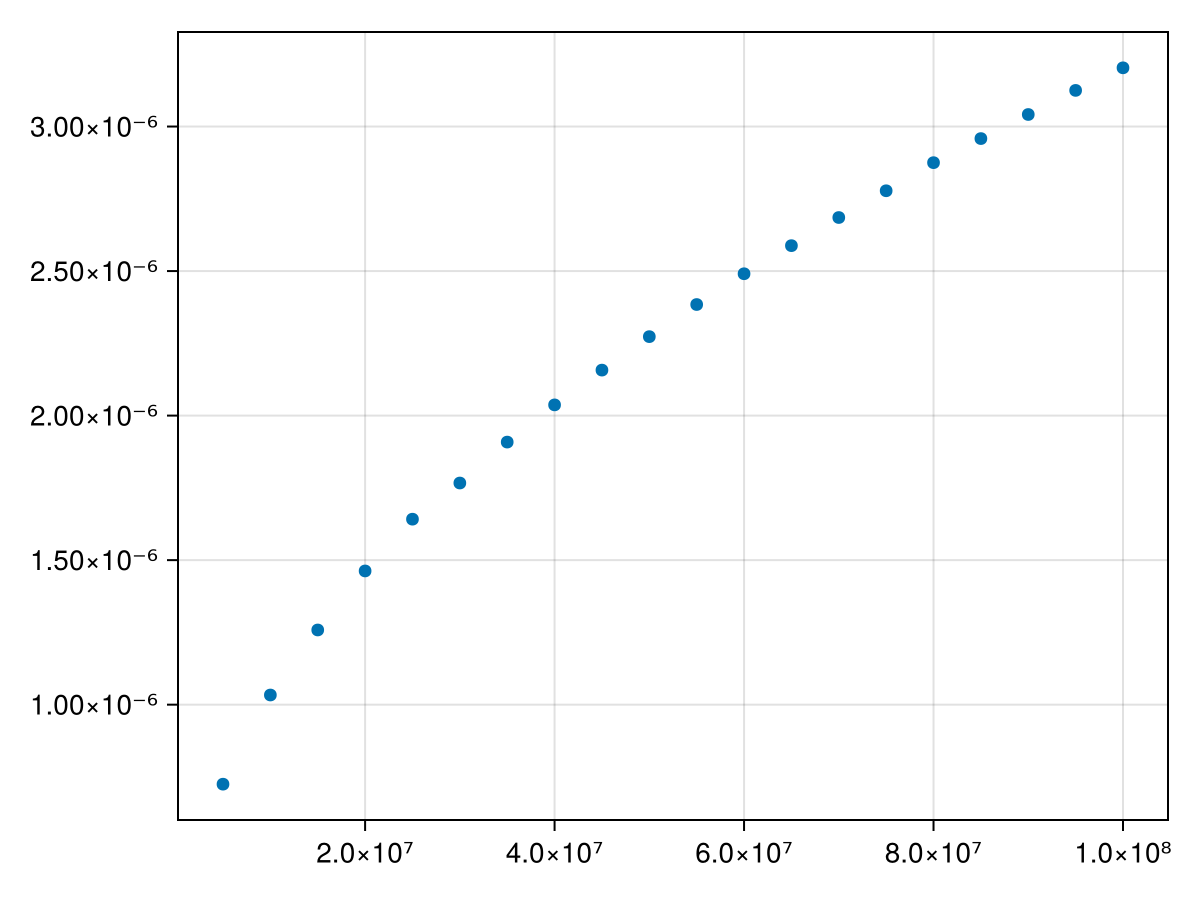

In [41]:
fig, ax = scatter(the_primes, prime_times)

Let's build a model with just a constant term, a square root and a log term based on the plot:

In [43]:
fit5 = curve_fit((t, p) -> (@. p[1] + p[2]*sqrt(t)+p[3]*log(t)), the_primes, prime_times, [1e-4, 1e-4,1e-4]);

In [44]:
fit5.param

3-element Vector{Float64}:
 -2.953825655513417e-7
  3.100868055410674e-10
  2.149675470924119e-8

In [45]:
confidence_interval(fit5)

3-element Vector{Tuple{Float64, Float64}}:
 (-5.918575214564515e-7, 1.092390353768081e-9)
 (3.0313215151862614e-10, 3.170414595635087e-10)
 (1.931069332120419e-9, 4.106244008636196e-8)

Only the $\sqrt{n}$ term is significant.  Let's fit the model to just that one:

In [46]:
fit6 = curve_fit((t,p) -> p[1].*sqrt.(t), the_primes, prime_times, [1e-6]);

In [47]:
fit6.param

1-element Vector{Float64}:
 3.215242673082481e-10

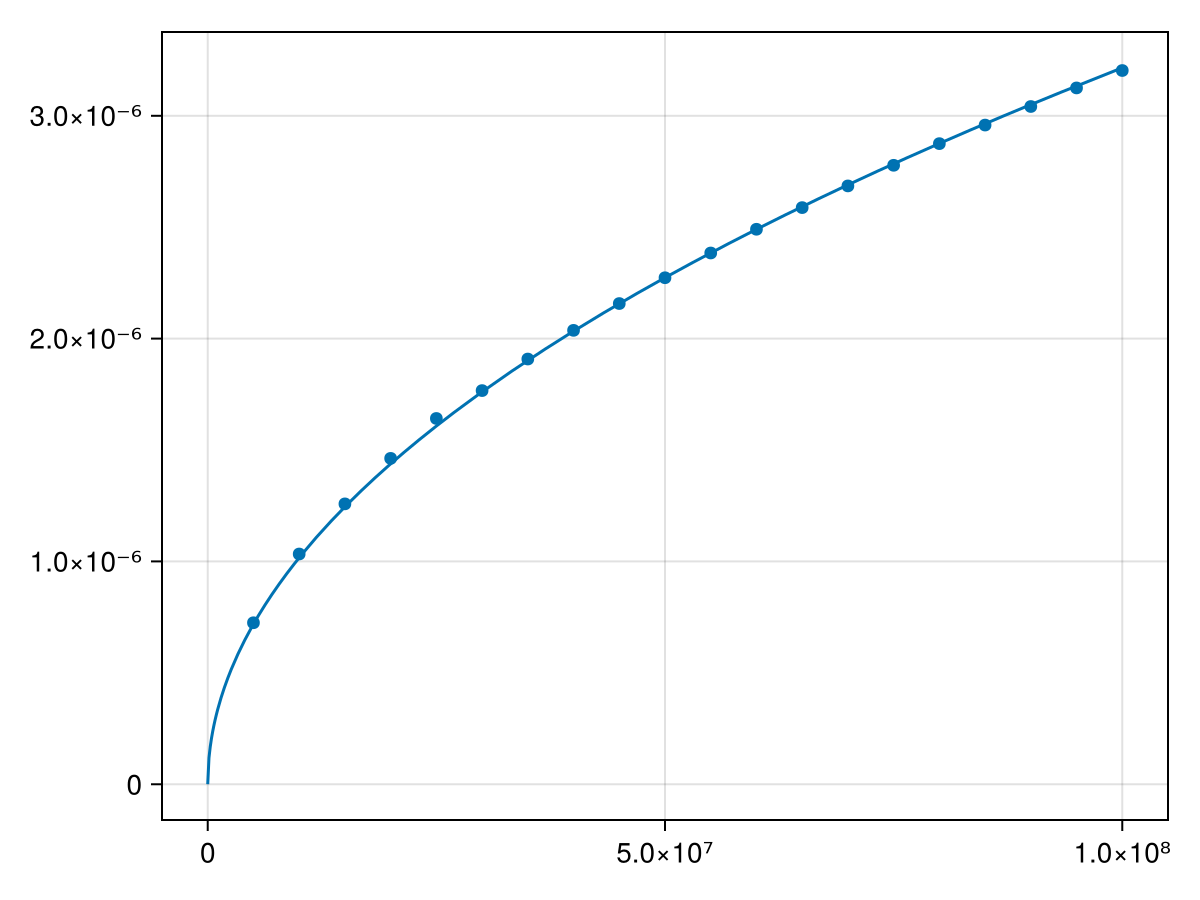

In [48]:
lines!(ax,1..100_000_000,t->fit6.param[1]*sqrt(t))
fig

This shows using some data that the order of operations (big-O) of finding prime numbers using this algorithm is $O(\sqrt{n})$